# Pressure

In [1]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.model.gae import GAE
from torch_geometric.loader import DataLoader
from src.training.train_cf import train
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/CF_NACA0012.yaml')
set_seed(config['config']['seed'])

train_dataset = GraphDataset(config = config['config'], split = 'train')
val_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1, 
                          shuffle=False,
                          num_workers=config['training']['num_workers'])

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])
    
surface_mask = train_dataset.surface_mask

linear_ae_input_size = train_dataset[0].x.shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1]
model = GAE(config = config, ae_input_size = linear_ae_input_size).to(device)

In [2]:
train_dataset[0]

Data(x=[512, 5], edge_index=[2, 1306], edge_attr=[1306, 2], y=[512, 3], pos=[512, 2], edge_weight=[1306], params=[2])

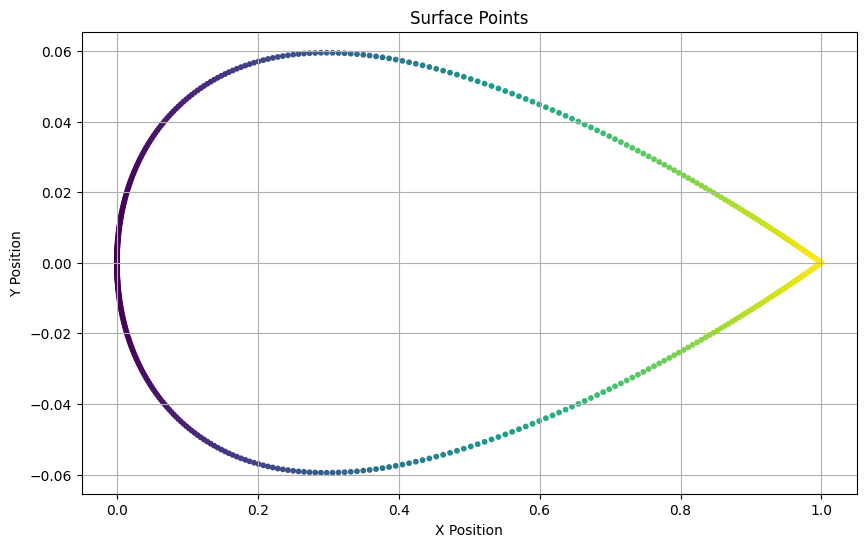

In [3]:
import matplotlib.pyplot as plt
surface_point = train_dataset[0].pos
plt.figure(figsize=(10, 6))
plt.scatter(surface_point[:, 0].cpu().numpy(), surface_point[:, 1].cpu().numpy(), c=train_dataset[0].x[:, 0].cpu().numpy(), cmap='viridis', s=10)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Surface Points')
plt.grid(True)
plt.show()

## Training

In [4]:
train_dataset[0].x.std(), train_dataset[0].x.mean()

(tensor(2.8227), tensor(1.4948))

In [5]:
data = train_dataset[0].to(device)

print(data.edge_attr.shape)  # should be [E, D] where D >= 1

torch.Size([1306, 2])


In [6]:
assert not torch.isnan(data.edge_attr).any(), "edge_attr contains NaNs"
assert not torch.isinf(data.edge_attr).any(), "edge_attr contains Infs"

In [7]:
data.edge_index.shape

torch.Size([2, 1306])

In [8]:
train_dataset[0].y.float()

tensor([[-1.8903e+00, -2.2717e-01, -7.9031e-01],
        [-1.4589e+00, -6.7710e-04, -6.0336e-01],
        [ 5.6551e-03,  3.6641e-01, -7.4927e-01],
        ...,
        [-9.6587e-03, -5.7994e-01, -9.5679e-01],
        [ 8.2723e-03, -5.8508e-01, -8.9469e-01],
        [-6.2646e-01, -4.2621e-01, -7.5963e-01]])

In [ ]:
history = train(model = model, 
                device = device, 
                surface_mask = surface_mask,
                lambda_surface=1,
                train_loader = train_loader, 
                is_val = True,
                val_loader = val_loader, 
                start_up_epoch=20,
                save_best_model=True,
                save_history=True,
                config = config['training'])

train_history, val_history = history

 84%|████████▍ | 4192/5000 [2:55:42<14:03,  1.04s/it, train_loss=0.002244, map_loss=0.001320, reconstruction_loss=0.000924, val_loss=0.028682, val_reconstruction_loss=0.027112, val_map_loss=0.001570]  

In [ ]:
from src.utils.commons import save_config
save_config(config, task='surface')

### Plot train total loss and val total loss

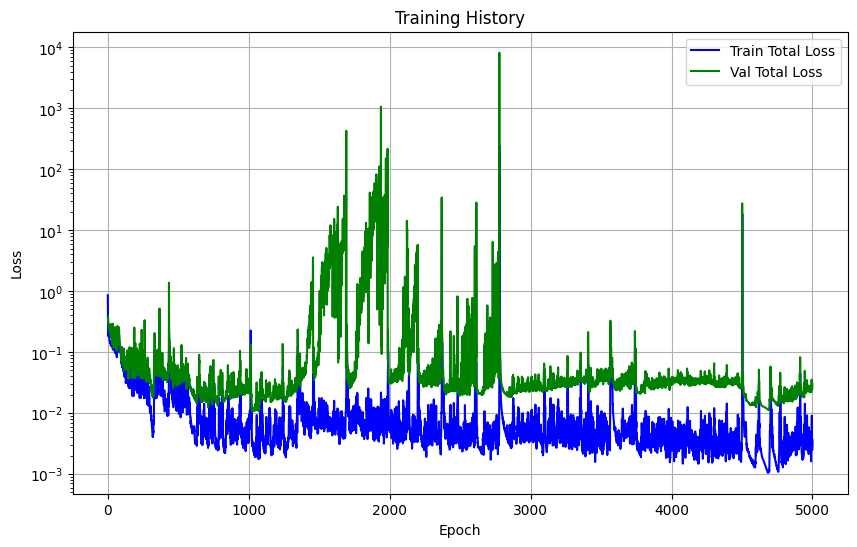

In [ ]:
import pickle
import matplotlib.pyplot as plt
from src.utils.commons import get_config

config = get_config('configs/CF_NACA0012.yaml')
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']
model_name = config['training']['model_name']
with open(f"artifacts/surface/{model_name}/{model_name}_history_{num_epochs}.pkl", 'rb') as f:
    # Load the history dictionary
    train_history = pickle.load(f)
    val_history = pickle.load(f)
    
train_total_loss = train_history['train_loss']
val_total_loss = val_history['val_loss']    

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_total_loss, label='Val Total Loss', color='green')
# plt.ylim(0.0001, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

### Plot train loss history

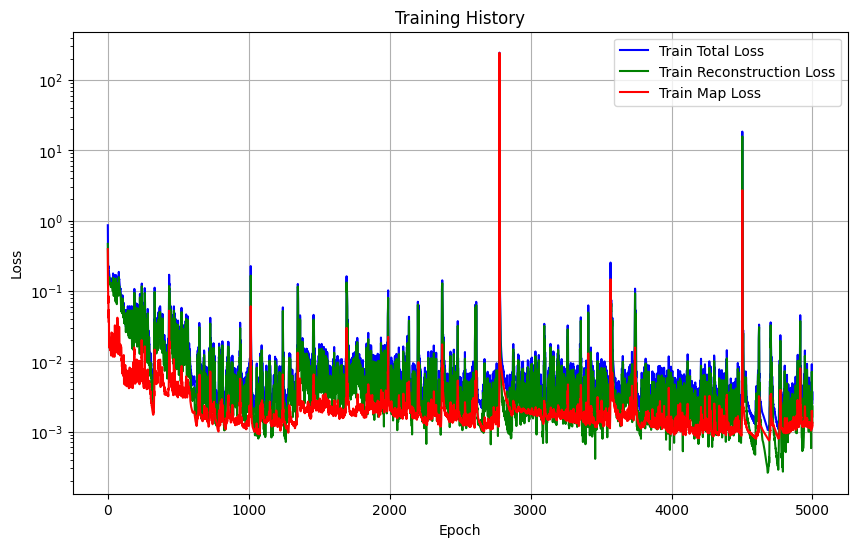

In [ ]:
train_total_loss = train_history['train_loss']
train_reconstruction_loss = train_history['reconstruction_loss']
train_map_loss = train_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(train_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(train_map_loss, label='Train Map Loss', color='red')
# plt.ylim(0.0001, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

### Plot validation loss history

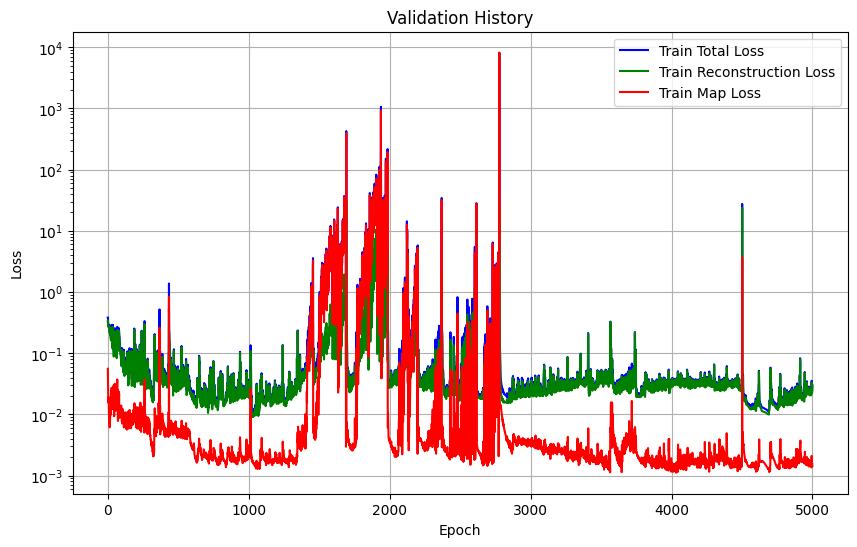

In [ ]:
val_total_loss = val_history['val_loss']
val_reconstruction_loss = val_history['reconstruction_loss']
val_map_loss = val_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(val_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(val_map_loss, label='Train Map Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0.0001, 1)
# plt.ylim(0.001, 10)
plt.title('Validation History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

## Plot results

### Matplotlib Plotting

In [2]:
from src.utils.plot import Plot
from src.utils.commons import load_model
import gc
import numpy as np
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from src.data.loader import GraphDataset
from src.utils.commons import get_config

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/CF_NACA0012.yaml')
set_seed(config['config']['seed'])
num_epochs = config['training']['epochs']
model_name = config['training']['model_name']

train_dataset = GraphDataset(config = config['config'], split = 'train')
val_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()

linear_ae_input_size = train_dataset[0].x.shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1]
# model = GAE(config = config, ae_input_size = linear_ae_input_size).to(device)
plot = Plot(train_dataset=train_dataset, val_dataset=val_dataset, model=model)

SyntaxError: non-default argument follows default argument (plot.py, line 212)

Original

In [ ]:
index = 10

test_plot_data = val_dataset[index].to(device)
test_param = test_plot_data.params

estimated_x, latent_variables, estimated_latent_variables = model(test_plot_data, test_param)
estimated_x = estimated_x.detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(test_plot_data.pos[:, 0].cpu().numpy(), estimated_x[:, 1], label='Estimated Cp', color='blue')
plt.plot(test_plot_data.pos[:, 0].cpu().numpy(), test_plot_data.y[:, 1].cpu().numpy(), label='Ground Truth Cp', color='red')

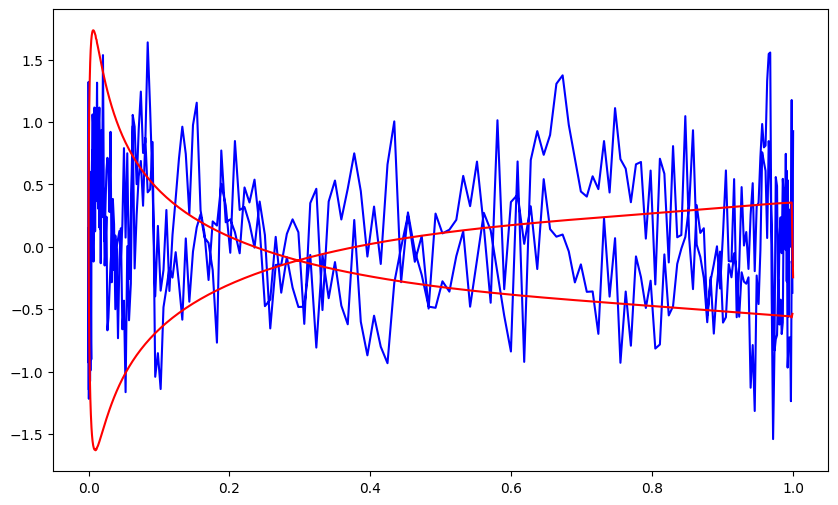

MSE Error

In [ ]:
def relative_error(pred, target, eps=1e-8):
    return torch.abs(pred - target) / (torch.abs(target) + eps)

In [ ]:
from torch.nn.functional import mse_loss
# error = relative_error(pred=torch.tensor(estimated_x, device=test_plot_data.x.device), target=test_plot_data.x)
error= mse_loss(input=torch.tensor(estimated_x, device=test_plot_data.x.device), target=test_plot_data.x, reduction='mean')
print(f"Mean Squared Error: {error.item()}")

Mean Squared Error: 0.0003804029256571084


# Post processing

In [ ]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from itertools import product
from warnings import filterwarnings

from src.utils.commons import get_config, get_device, set_seed
from torch_geometric.loader import DataLoader
from src.data.loader import GraphDataset
from src.utils.commons import get_config, load_model

filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config('configs/CF_NACA0012.yaml')
set_seed(config['config']['seed'])
device = get_device()
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']

test_dataset = GraphDataset(config = config['config'], split = 'val')
test_loader = DataLoader(dataset=test_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])
mu1 = np.array([10e4, 15e4, 20e4, 25e4, 30e4, 35e4, 40e4, 45e4, 50e4, 55e4, 60e4, 65e4, 70e4, 75e4, 80e4, 85e4, 90e4, 95e4, 100e4])
mu2 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
mu_space = [mu1, mu2]
params = torch.tensor(np.array(list(product(*mu_space))))
params = params.to(device)
surface_mask = test_dataset.surface_mask
num_graphs = test_dataset.num_graphs

model = load_model(f"artifacts/surface/{model_name}/{model_name}_best_model_{num_epochs}.pth", config=config, num_graphs=test_dataset.num_graphs)
model = model.to(device)

In [ ]:
from src.utils.metrics import mse_error, mae_error, rmse_error, relative_error
from src.training.test import test

error_func = [mse_error, mae_error, rmse_error, relative_error]
test_params = params[test_dataset.file_index]
test_results, total_error = test(model, test_params, test_loader, device, error_func)

In [ ]:
total_error

{'total_mse_error': 0.03420029986465787,
 'total_mae_error': 0.06892202448467781,
 'total_rmse_error': 0.16997587942966708,
 'total_relative_error': 4.322089583647472}

# Cp

Good: 5, 6
Hmm: 3, 4, 8
Bad: 1, 2, 9, 10, 11

In [ ]:
index = 5

MSE: 5.966353455733042e-08
Relative Error: 2.4929072424129117e-06


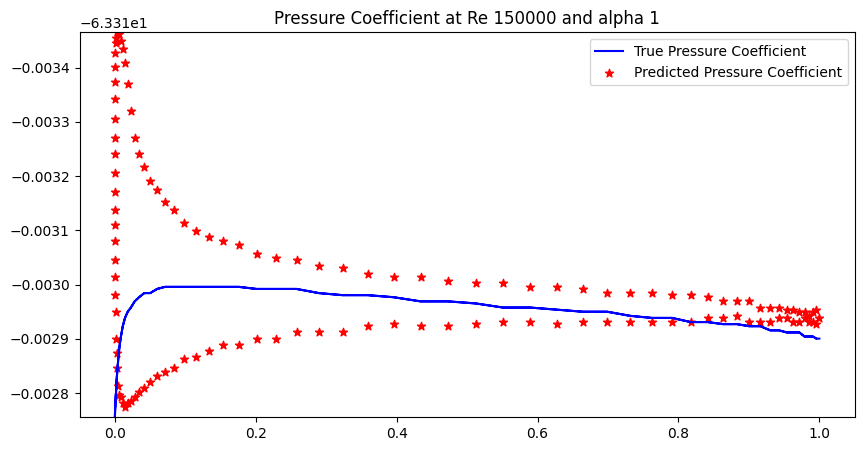

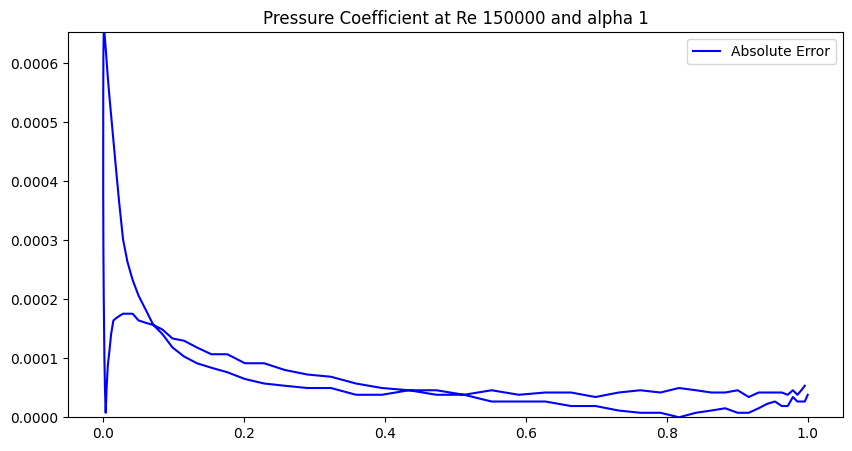

In [ ]:
from src.training.test import single_test

rho_inf = 2.13163
R = 287.058
T_inf = 300
viscosity_inf = 1.853e-05
v_inf = 52.1572 # THIS HAS TO BE CHANGED FOR EACH RE

p_inf = rho_inf * R * T_inf
q_inf = 0.5 * rho_inf * v_inf**2

model = model.to(device)
test_data = test_dataset[index]
test_data = test_data.to(device)
test_param = params[test_dataset.file_index[index]]
file_key = test_dataset.file_keys[0].split('_')[0] + '_' + str(test_dataset.file_index[index])
surface_mask = test_dataset.surface_mask
surface_point = test_data.pos[surface_mask].detach().cpu().numpy()
upper_surface_point = surface_point[surface_point[:, 1] >= 0]
lower_surface_point = surface_point[surface_point[:, 1] < 0]

# VTU FILE
# import pyvista as pv
# import meshio
# vtu_path = f"dataset/full/flow_Re_{int(test_param[0])}_alpha_{int(test_param[1])}.vtu"
# mesh_path = r"dataset/unsteady_naca0012.su2"
# grid = pv.read(vtu_path)
# surface_p = grid["Pressure"][surface_mask,]
# surface_cp = grid["Pressure_Coefficient"][surface_mask,]
# surface_p.shape

# truth
surface_p_graph = test_data.x[surface_mask].detach().cpu().numpy()
surface_cp_graph = test_dataset.h5_file[file_key]['Cp'][:][surface_mask]
surface_cp_graph = (surface_p_graph - p_inf) / q_inf
surface_p_graph.shape

#predicted
pred_p = single_test(model, test_param, test_data, device).detach().cpu().numpy()
surface_pred_p = pred_p[surface_mask,]
surface_pred_cp = (surface_pred_p - p_inf) / q_inf
surface_pred_p.shape

cp_mse = np.mean((surface_cp_graph - surface_pred_cp) ** 2)
print(f"MSE: {cp_mse}")
cp_relative = np.mean(np.abs(surface_pred_cp - surface_cp_graph) / np.abs(surface_cp_graph))
print(f"Relative Error: {cp_relative}")

plt.figure(figsize=(10, 5))
plt.plot(surface_point[:, 0], surface_cp_graph, label="True Pressure Coefficient", color="blue")
plt.scatter(surface_point[:, 0], surface_pred_cp, label="Predicted Pressure Coefficient", color="red", marker="*")
plt.ylim(max([max(surface_cp_graph), max(surface_pred_cp)]), min([min(surface_cp_graph), min(surface_pred_cp)]))
plt.title(f"Pressure Coefficient at Re {int(test_param[0])} and alpha {int(test_param[1])}")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(surface_point[:, 0], np.abs(surface_cp_graph - surface_pred_cp), label="Absolute Error", color="blue")
plt.ylim(0, max([max(np.abs(surface_cp_graph - surface_pred_cp))]))
plt.title(f"Pressure Coefficient at Re {int(test_param[0])} and alpha {int(test_param[1])}")
plt.legend()
plt.show()

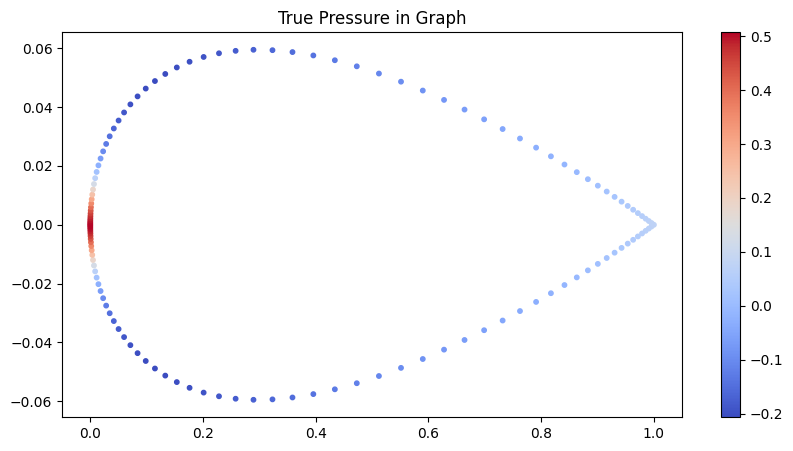

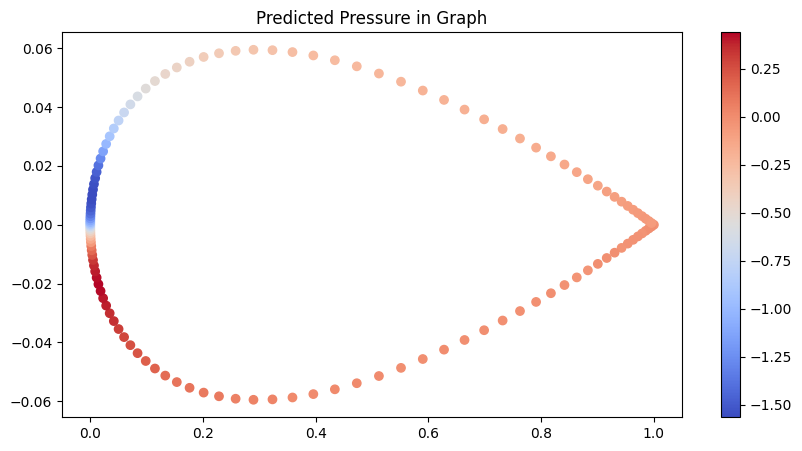

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(surface_point[:, 0], surface_point[:, 1], c=surface_p_graph, cmap="coolwarm", s=10)
plt.colorbar()
plt.title("True Pressure in Graph")
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(surface_point[:, 0], surface_point[:, 1], c=surface_pred_p, cmap="coolwarm")
plt.colorbar()
plt.title("Predicted Pressure in Graph")
plt.show()

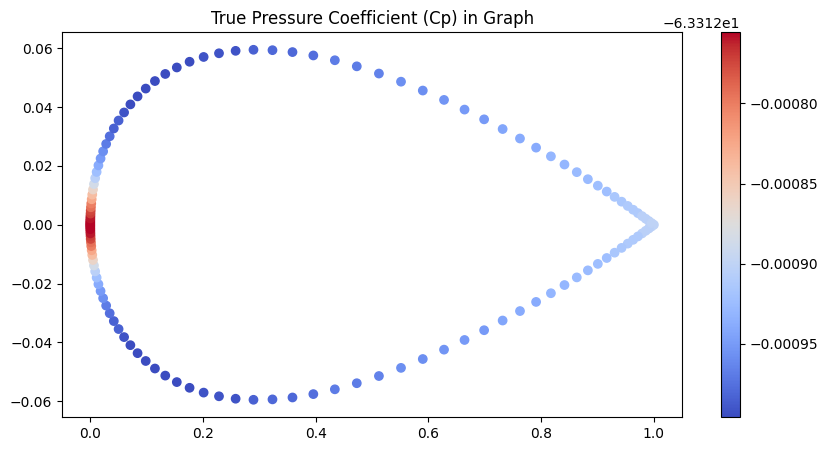

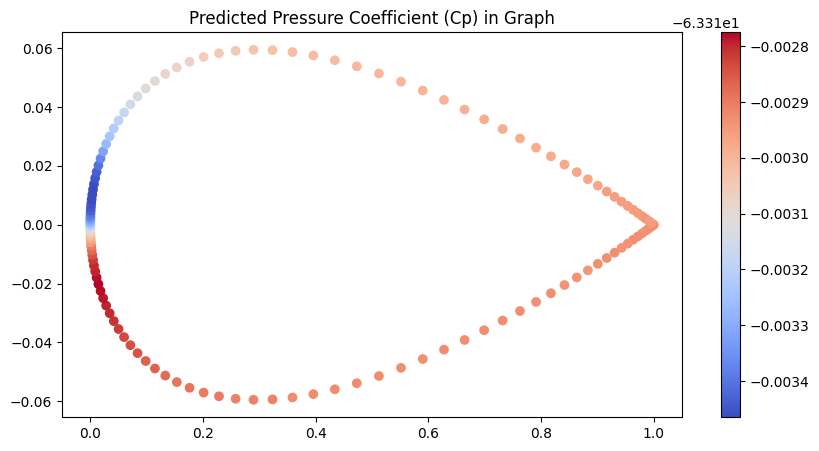

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(surface_point[:, 0], surface_point[:, 1], c=surface_cp_graph, cmap="coolwarm")
plt.colorbar()
plt.title("True Pressure Coefficient (Cp) in Graph")
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(surface_point[:, 0], surface_point[:, 1], c=surface_pred_cp, cmap="coolwarm")
plt.colorbar()
plt.title("Predicted Pressure Coefficient (Cp) in Graph")
plt.show()